In [1]:
#!/usr/bin/python3 (3.8.10 x64)
import numpy as np
import pygad
import os
import mazes

Create a function that reads the 2D representation of a maze and returns the shortest path found by a genetic algorithm.

In [2]:
# Convert mazes into 2D array of chars
def get_maze(maze):
    res = []
    for i in range(len(maze)):
        row = list(list(maze[i])[0])
        res.append(row)
        
    return np.array(res)

In [3]:
# Convert mazes
maze1 = get_maze(mazes.maze1)
maze2 = get_maze(mazes.maze2)
maze3 = get_maze(mazes.maze3)
maze4 = get_maze(mazes.maze4)
maze5 = get_maze(mazes.maze5)
maze6 = get_maze(mazes.maze6)
maze7 = get_maze(mazes.maze7)
maze3_T = get_maze(mazes.maze3_T) 
maze4_T = get_maze(mazes.maze4_T) 
maze5_T = get_maze(mazes.maze5_T) 
maze7_T = get_maze(mazes.maze7_T) 

In [4]:
# Return a tuple containing indices of start
def find_start(maze):
    '''
        Return an array containing indices of start
    '''
    maze = np.array(maze)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == "S":
                return i,j

In [5]:
# Return a tuple containing indices of end
def find_end(maze):
    '''
    Return an array containing indices of end
    '''
    maze = np.array(maze)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == "E":
                return i,j

Solution will be encoded as follows:
* It will be a vector of values (np array)
* Each value will span from 0 to 3
* Each value corresponds to a direction 
* * 0 - up
* * 1 - down
* * 2 - left
* * 3 - right

Maze: `h x w` matrix, possible values of maze[i,j]:
* `#` - wall
* `.` - valid field
* `S` - starting field
* `E` - ending field

Maze[i,j] gives:
*   (0) up = Maze[i-1, j]
*   (1) down = Maze[i+1, j]
*   (2) left = Maze[i, j-1]
*   (3) right = Maze[i, j+1]

In [6]:
solutions = [False]
def set_solutions_false():
    solutions[0] = False
    
def shortest_path(maze, i, j, visited):
    if [i,j] in visited:
        return 0
    
    path_len = 0
    visited.append([i,j])
        
    if maze[i,j] == "E":
        solutions[0] = True;
        return 0
    
    if i > 0 and maze[i-1, j] != "#":
        path_len = shortest_path(maze, i-1, j, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len
    
    if j > 0 and maze[i, j-1] != "#":
        path_len = shortest_path(maze, i, j-1, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len
        
    if i < maze.shape[0]-1 and maze[i+1, j] != "#":
        path_len = shortest_path(maze, i+1, j, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len
         
    
    if j < maze.shape[1]-1 and maze[i, j+1] != "#":
        path_len = shortest_path(maze, i, j+1, visited) + 1
        if solutions[0]:
            maze[i,j] = "0"
            return path_len    
        
    visited.remove([i,j])

    solutions[0] = False
    return path_len

solutions = [False]

In [7]:
def get_shortest_path(maze):
    set_solutions_false()
    start = find_start(maze)
    m = maze.copy()
    res = shortest_path(m, start[0], start[1], [])
    return res, m
    

In [8]:
# Choose which maze to solve
maze = maze4


It is hard to find the reward ratio at which the algorithm will choose to go around a wall but still persist until finding the end

In [9]:
path_len, _ = get_shortest_path(maze)
y, x = find_start(maze)

end = find_end(maze)

def fitness(solution, solution_index):
    '''
        Takes in a maze and a solution and solution_index
        Returns a scalar score
    '''
    score = 0
    seen = []

    i, j = y, x
    valid = 0
    invalid = 0
    backtrack_count = 0

    
    for move in solution:

        # Determine new position
        if move == 0:
            i -= 1
        elif move == 1:
            i += 1
        elif move == 2:
            j -= 1
        elif move == 3:
            j += 1     

 
        # Out of bounds
        if i < 0 or j < 0 or i > len(maze[0])-1 or j > len(maze[1])-1:
            if score < 0:
                return score
            return -score

        if (i,j) in seen:
            score -= 4
            backtrack_count += 1
        

        # Valid field
        if maze[i, j] == ".":
            score += 4;        
            valid += 1
            seen.append((i,j))
        
        # Finish
        elif maze[i, j] == "E":
            
            moves = valid + invalid
            # Punish long paths, invalid fields and backtracking, reward valid fields, 
            score +=  990 + valid**2 - invalid**2 - moves**1.2 - backtrack_count*2
                            
            return score
        
        
        # Penalize wall and path length
        elif maze[i, j] == "#":
            #if score < 0:
            #    return score
            #return -score
            score -= 100  # (path_len - ix)**2
            invalid += 1
            seen.append((i,j))
        #score -= 1
    
    return score


In [10]:
num_generations = 1500
num_parents_mating = 100

solutions_per_pop = 100

num_genes, dfs_solution = get_shortest_path(maze)
num_genes =  maze.shape[0]**2

init_range_low = 0
init_range_high = 4

parent_selection_type = "sss"
keep_parents = 50

crossover_type = "single_point"
crossover_probability = 0.1

mutation_type = "swap"
mutation_probability = 0.8

In [11]:
def callback_gen(ga_instance):
    print("Generation : ", ga_instance.generations_completed)
    print("Fitness of the best solution :", ga_instance.best_solution()[1])

In [12]:
unique_vals = []
def on_crossover(ga_instance, children):
    print(ga_instance.generations_completed, children)
    unique_vals.append(children[0][0])
    
first_child = []
def on_mutation(ga_instance, children):
    first_child.append(children[0])

In [13]:
ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=solutions_per_pop,
                        num_genes=num_genes,
                        gene_type=int,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        random_mutation_min_val=0,
                        random_mutation_max_val=3,
                        #suppress_warnings=True,
                        gene_space=[0,1,2,3],
                        mutation_probability=mutation_probability,
                        on_generation=callback_gen,
                        random_seed=420,
                        #on_crossover=on_crossover
                        )

In [14]:
def visualize(maze, solution):
    m = maze.copy()
    i, j = find_start(maze)
    sol = []
    solved = False
    invalid = 0
    ix = 0
    for step in solution:
        ix += 1
        
        try:
     
            if step == 0:
                sol.append("U")
                i -= 1
            elif step == 1:
                sol.append("D")
                i += 1
            elif step == 2:
                sol.append("L")
                j -= 1
            elif step == 3:
                sol.append("R")
                j += 1
                
            if m[i,j] == "#":
                invalid += 1
                
            if m[i,j] == "E":
                solved = True
                m[i,j] = "X"
            if (i > -1 and j > -1 and solved == False):
                m[i, j] = f"0" 
            if solved:
                return m, sol, invalid. solved
        except Exception as e: #IndexError:
            #print(f"Exception: {e}")
            pass
            
    return m, sol, invalid, solved


In [15]:
ga_instance.run()

Generation :  1
Fitness of the best solution : 809.4141855133685
Generation :  2
Fitness of the best solution : 809.4141855133685
Generation :  3
Fitness of the best solution : 908.1013516926939
Generation :  4
Fitness of the best solution : 908.1013516926939
Generation :  5
Fitness of the best solution : 908.1013516926939
Generation :  6
Fitness of the best solution : 908.1013516926939
Generation :  7
Fitness of the best solution : 908.1013516926939
Generation :  8
Fitness of the best solution : 908.1013516926939
Generation :  9
Fitness of the best solution : 908.1013516926939
Generation :  10
Fitness of the best solution : 908.1013516926939
Generation :  11
Fitness of the best solution : 908.1013516926939
Generation :  12
Fitness of the best solution : 908.1013516926939
Generation :  13
Fitness of the best solution : 908.1013516926939
Generation :  14
Fitness of the best solution : 908.1013516926939
Generation :  15
Fitness of the best solution : 908.1013516926939
Generation :  16
Fi

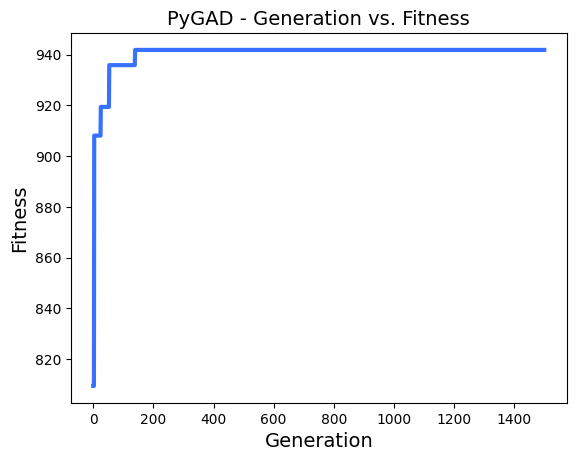

Parameters of the best solution : [0 0 2 2 3 3 0 0 0 0 2 3 1 3 0 2 2 2 1 0 0 0 2 1 2 1 0 1 0 0 2 3 2 1 0 3 3
 0 3 0 3 2 2 1 3 2 3 2 1 1 0 0 2 2 3 3 0 0 0 0 2 3 1 3 0 2 2 2 1 0 0 0 2 1
 2 1 0 1 0 0 2 3 2 1 0 3 3 0 1 0 3 2 2 1 3 2 3 2 1 1] index =  0
Fitness value of the best solution = 941.8742674679168


In [16]:
ga_instance.plot_fitness()
#ga_instance.save("maze2-solved-2")

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution), "index = ", solution_idx)
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
#print(unique_vals)
#prediction = np.sum(np.array(ins)*solution)
#print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

In [17]:
m, sol, incorrect, solved = visualize(maze, solution)

_, dfs_solution = get_shortest_path(maze)
#print("solution", sol)
print("GA\n", m, len(solution), "incorrect:", incorrect, "solved", solved ,"\n")
#print("DFS\n", dfs_solution)

GA
 [['#' '#' '#' '#' '#' 'X' '#' '#' '#' '#']
 ['#' '.' '.' '.' '#' '0' '.' '.' '.' '#']
 ['#' '.' '#' '#' '#' '0' '#' '#' '.' '#']
 ['#' '.' '#' '0' '0' '0' '.' '.' '.' '#']
 ['#' '.' '#' '#' '#' '0' '#' '#' '#' '#']
 ['#' '.' '.' '.' '.' 'S' '.' '.' '.' '#']
 ['#' '#' '#' '#' '#' '.' '#' '#' '.' '#']
 ['#' '.' '.' '#' '#' '.' '#' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '.' '.' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#']] 100 incorrect: 60 solved True 



### Task 2 - overriding the mutate function

In [18]:
def decode_genome(genome, i,j):
    # Up
    if genome == 0:
        i -= 1
    # Down
    elif genome == 1:
        i += 1
    # Left
    elif genome == 2:
        j -= 1
    #Right
    elif genome == 3:
        j += 1
        
    return i,j

In [19]:
def get_parent_scores(parent1, parent2):
    '''
        Takes in 2 parents and returns length of longest valid prefix for each
    '''
    
    i,j = find_start(maze)
    i1, j1 = i, j
    i2, j2 = i, j
    
    valid_1, valid_2 = 0, 0
    end1, end2 = False, False
    
    for ix in range(len(parent1)):
        i1, j1 = decode_genome(parent1[ix], i1, j1)
        i2, j2 = decode_genome(parent2[ix], i2, j2)
        
        if i1 < 0 or j1 < 0 or i1 > maze.shape[0]-1 or j1 > maze.shape[1]-1 or maze[i1, j1] == "#":
            valid_1 = ix
            end1 = True
        if i2 < 0 or j2 < 0 or i2 > maze.shape[0]-1 or j2 > maze.shape[1]-1 or maze[i2, j2] == "#":
            valid_2 = ix
            end2 = True
            
        if end1 and end2:
            break
        
    return valid_1, valid_2
            
    

In [20]:
def crossover_func(parents, offspring_size, ga_instance):
    '''
        Takes in parents and returns a new solution by single-point crossover. 
        It takes walls and valid path in account and tries to crossover at the point where we hit a wall
    '''
    
    offspring = []
    idx = 0
    # Get all pairs of parents
    while len(offspring) != offspring_size[0]:
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx+1) % parents.shape[0], :].copy()
        
        # Instead of random split point, we choose a point such that it allows the longest valid prefix
        # Track where each goes and take the longer valid prefix, crossover at the point where it hits wall
        n_valid_1, n_valid_2  = get_parent_scores(parent1, parent2)
        # Parent 1 has longer valid prefix
        if n_valid_1 >= n_valid_2:
            split_point = n_valid_1
            parent1[split_point:] = parent2[split_point:]
            offspring.append(parent1)
        elif n_valid_1 < n_valid_2:
            split_point = n_valid_2
            parent2[split_point:] = parent1[split_point:]
            offspring.append(parent2)
            
        idx += 1
    
    return np.array(offspring)

In [21]:
print(crossover_func(np.array([[0,2,0], [1,2,3]]), (1,1), ga_instance))

[[0 2 3]]


In [22]:
maze

array([['#', '#', '#', '#', '#', 'E', '#', '#', '#', '#'],
       ['#', '.', '.', '.', '#', '.', '.', '.', '.', '#'],
       ['#', '.', '#', '#', '#', '#', '#', '#', '.', '#'],
       ['#', '.', '#', '.', '.', '.', '.', '.', '.', '#'],
       ['#', '.', '#', '#', '#', '.', '#', '#', '#', '#'],
       ['#', '.', '.', '.', '.', 'S', '.', '.', '.', '#'],
       ['#', '#', '#', '#', '#', '.', '#', '#', '.', '#'],
       ['#', '.', '.', '#', '#', '.', '#', '#', '#', '#'],
       ['#', '#', '.', '.', '.', '.', '.', '.', '.', '#'],
       ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#']], dtype='<U1')

In [23]:
def mutation_func(offspring, ga_instance):
    '''
        Mutates a random gene on each chromosome, but accounts for walls and backtracking
    '''
    
    # We can detect backtrack at the cost of taking more paths through walls
    DETECT_BACKTRACK = False
    
    #print(np.random.choice(range(offspring.shape[0])))
    #print(maze)
    # Get random indices
    for chromosome_idx in range(offspring.shape[0]):
        random_gene_idx = np.random.choice(range(offspring.shape[1]))
        
        #print(chromosome_idx, random_gene_idx)
        c = chromosome_idx        
            
        # random gene 
        random_gene_value = np.random.choice(4)
        
        # check for walls
        y,x = find_start(maze)    
        i,j = y,x
        
        #print("Start = ", i, j)
        
        # Get the path
        g = random_gene_idx
        gene = offspring[c,g]
        
        #print("random gene idx", random_gene_idx)
        
        # i j are the position we are at before the genome we are about to mutate
        for step in range(random_gene_idx):
            i, j = decode_genome(offspring[c,step], i, j)
        #print(f"By moving by {offspring[0:random_gene_idx]} we get to {i},{j}")
        # Now we are at the gene we want to mutate, check if mutation creates invalid path
        a, b = i, j     # So we dont corrupt the indices
        
        # Current gene value
        old_gene_value = offspring[c, g]
        previous_gene = -1
        opposite_gene = -1
        if g-1 >= 0:
            previous_gene = offspring[c, g-1]
            if previous_gene == 0:
                opposite_gene = 1
            elif previous_gene == 1:
                opposite_gene = 0
            elif previous_gene == 2:
                opposite_gene = 3
            else: 
                opposite_gene = 2
        
        # Value that should replace current gene
        new_gene_value = random_gene_value
        a, b = decode_genome(new_gene_value, a, b)
        #print("new gene at position ", random_gene_idx, " is ", new_gene_value, "(was ", old_gene_value, ")")
        # Check if new gene value hits a wall + avoid infinite loop           
        tries = 0
        while (a < 0 or b < 0 or a > maze.shape[0]-1 or
               b > maze.shape[1]-1 or maze[a,b] == "#" or 
               new_gene_value == old_gene_value or
               (DETECT_BACKTRACK and new_gene_value == opposite_gene)
               ) and tries < 4:
            
            a, b = i, j
            #print("starting coords", a, b)
            new_gene_value += 1
            new_gene_value %= 4
            a, b = decode_genome(new_gene_value, a, b)
            tries += 1
            #print("new gene at position ", random_gene_idx, " is ", new_gene_value, "(was ", old_gene_value, ")")
            
                   
        #print("old gene: ", old_gene_value, "new gene", new_gene_value)         
        offspring[c, g] = new_gene_value
        #print("Brings us to", maze[a,b], a, b)
        
    #print(random_gene_value)
    #offspring[chromosome_idx, random_gene_idx] = random_gene_value
    
    return offspring

In [24]:
#print(mutation_func(np.array([[0,0,3,1],[3,3,2,0],[3,3,1,1]]),ga_instance))

In [25]:
maze = maze5

In [26]:
num_generations = 1500
num_parents_mating = 100

solutions_per_pop = 100

num_genes, dfs_solution = get_shortest_path(maze)
num_genes =  maze.shape[0]**2
num_genes += 1
print(num_genes)

init_range_low = 0
init_range_high = 4

parent_selection_type = "sss"
keep_parents = 50

crossover_type = "single_point"
crossover_probability = 0.1

mutation_type = mutation_func
mutation_probability = 0.8

226


In [27]:
custom_ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=solutions_per_pop,
                        num_genes=num_genes,
                        gene_type=int,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_func,
                        #crossover_probability=crossover_probability,
                        mutation_type=mutation_func,
                        random_mutation_min_val=0,
                        random_mutation_max_val=3,
                        #suppress_warnings=True,
                        gene_space=[0,1,2,3],
                        #mutation_percent_genes=mutation_percent_genes,
                        mutation_probability=mutation_probability,
                        on_generation=callback_gen,
                        random_seed=420,
                        #on_crossover=on_crossover
                        )

In [28]:
custom_ga_instance.run()

Generation :  1
Fitness of the best solution : 522.2749780457933
Generation :  2
Fitness of the best solution : 606.1510680753888
Generation :  3
Fitness of the best solution : 721.1767838023222
Generation :  4
Fitness of the best solution : 1017.1767838023222
Generation :  5
Fitness of the best solution : 1165.1767838023222
Generation :  6
Fitness of the best solution : 1165.1767838023222
Generation :  7
Fitness of the best solution : 2019.1009045785486
Generation :  8
Fitness of the best solution : 2019.1009045785486
Generation :  9
Fitness of the best solution : 2019.1009045785486
Generation :  10
Fitness of the best solution : 2019.1009045785486
Generation :  11
Fitness of the best solution : 2019.1009045785486
Generation :  12
Fitness of the best solution : 2019.1009045785486
Generation :  13
Fitness of the best solution : 2019.1009045785486
Generation :  14
Fitness of the best solution : 2019.1009045785486
Generation :  15
Fitness of the best solution : 2019.1009045785486
Generat

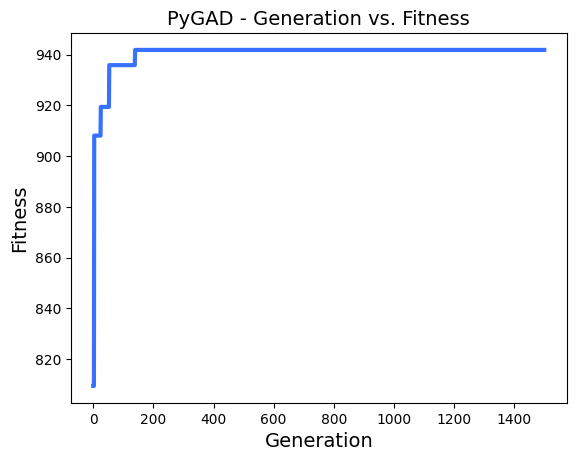

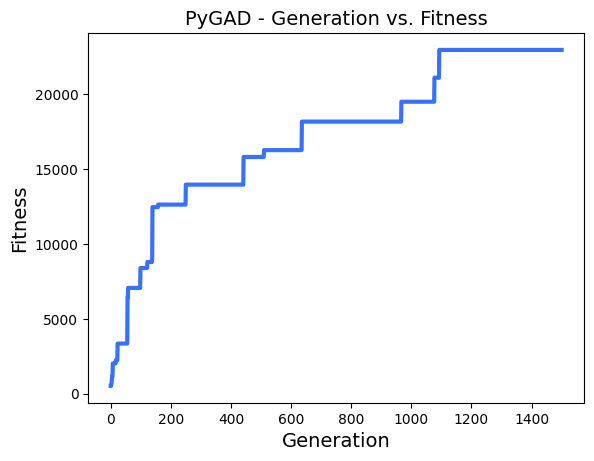

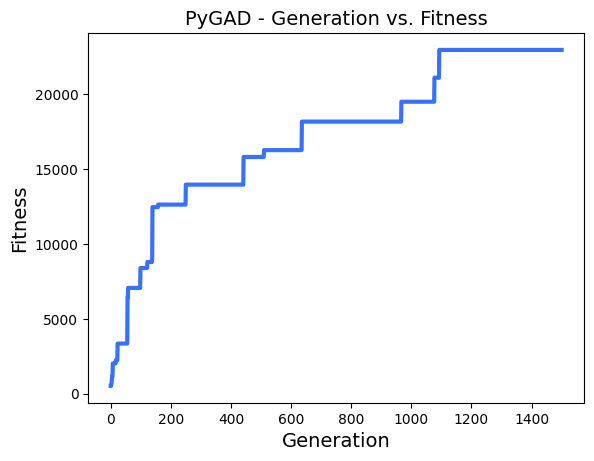

In [ ]:
ga_instance.plot_fitness()
custom_ga_instance.plot_fitness()


In [ ]:
ga_solution, ga_solution_fitness, ga_solution_idx = ga_instance.best_solution()
#print("Parameters of the best solution of default mutation : {solution}".format(solution=ga_solution), "index = ", ga_solution_idx)
print("Fitness value of the best solution of default mutation = {solution_fitness}".format(solution_fitness=ga_solution_fitness))

custom_ga_solution, custom_ga_solution_fitness, custom_ga_solution_idx = custom_ga_instance.best_solution()
#print("Parameters of the best solution of custom mutation : {solution}".format(solution=custom_ga_solution), "index = ", custom_ga_solution_idx)
print("Fitness value of the best solution of custom mutation = {solution_fitness}".format(solution_fitness=custom_ga_solution_fitness))

Fitness value of the best solution of default mutation = 941.8742674679168
Fitness value of the best solution of custom mutation = 22937.731060756643


In [ ]:
ga_m, ga_sol, ga_invalid, ga_solved = visualize(maze, ga_solution)
custom_ga_m, custom_ga_sol, custom_ga_invalid, custom_ga_solved = visualize(maze, custom_ga_solution)

shortest, dfs_solution = get_shortest_path(maze)
#print("solution", sol)
print("GA - default\n", ga_m, len(ga_sol), "invalid", ga_invalid, "solved", ga_solved, "\n")
print("GA - custom\n", custom_ga_m, len(custom_ga_sol), "| invalid:", custom_ga_invalid, " | solved:", custom_ga_solved, "\n")
#print("DFS\n", dfs_solution, shortest)

#ga_m.tofile("def-GA.txt")
#custom_ga_m.tofile("custom-GA.txt")

#with open("def-GA.txt", "w") as file:
#    file.write(ga_m)
#            
#with open("custom-GA.txt", "w") as file:
#    file.write(custom_ga_m)

GA - default
 [['#' '#' '#' 'E' '0' '0' '0' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '.' '0' '0' '0' '0' '.' '.' '.' '#' '#' '#' '.' '.' '#']
 ['#' '#' '0' '0' '0' '0' '#' '#' '.' '.' '.' '.' '.' '#' '#']
 ['#' '.' '0' '0' '0' '0' '#' '#' '.' '#' '#' '#' '.' '#' '#']
 ['#' '.' '#' '0' '#' '0' '0' '0' '0' '.' '#' '#' '.' '.' '#']
 ['#' '.' '.' '.' '.' '0' '#' '0' '0' '.' '.' '.' '#' '#' '#']
 ['#' '#' '#' '#' '.' '#' '#' '0' '#' '.' '#' '.' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '0' '#' '.' '.' '.' '.' '.' '#']
 ['#' '#' '#' '#' '#' '0' '0' '0' '#' '.' '#' '#' '#' '.' '#']
 ['#' '.' '.' '.' '.' '.' '.' '0' '.' '.' '#' '#' '#' '#' '#']
 ['#' '.' '#' '#' '#' '#' '.' 'S' '#' '.' '.' '.' '.' '#' '#']
 ['#' '#' '.' '.' '.' '.' '#' '.' '#' '#' '#' '#' '#' '#' '#']
 ['#' '.' '.' '#' '#' '.' '.' '.' '.' '.' '.' '.' '.' '.' '#']
 ['#' '#' '.' '.' '.' '#' '#' '#' '.' '#' '#' '.' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']] 100 invalid 40 solved False 

GA - custo

### Task 3 - Treasure

In [ ]:
def count_treasures(maze):
    count = 0
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            if maze[i,j] == "T":
                count += 1
                
    return count

In [ ]:
path_len, _ = get_shortest_path(maze)
y, x = find_start(maze)
treasures = count_treasures(maze)

end = find_end(maze)

def treasure_fitness(solution, solution_index):
    '''
        Takes in a maze and a solution and solution_index
        Returns a scalar score
    '''
    score = 0
    seen = []

    i, j = y, x
    valid = 0
    invalid = 0
    found_treasures = 0
    backtrack_count = 0
    
    for move in solution:

        # Determine new position
        if move == 0:
            i -= 1
        elif move == 1:
            i += 1
        elif move == 2:
            j -= 1
        elif move == 3:
            j += 1     

 
        # Out of bounds
        if i < 0 or j < 0 or i > len(maze[0])-1 or j > len(maze[1])-1:
            if score < 0:
                return score
            return -score

        if (i,j) in seen:
            backtrack_count += 1
            score -= 10
        

        # Valid field
        if maze[i, j] == ".":
            score += 4;        
            valid += 1
            seen.append((i,j))
        
        elif maze[i, j] == "T" and (i,j) not in seen:
            found_treasures += 1
            score += 4
        
        # Finish
        elif maze[i, j] == "E":
            
            moves = valid + invalid
            score +=  990 + valid**2 - invalid**2 - moves*3 + (found_treasures*2)**3 - backtrack_count**2
                            
            return score
        
        
        # Penalize wall and path length
        elif maze[i, j] == "#":
            #if score < 0:
            #    return score
            #return -score
            score -= 100  # (path_len - ix)**2
            invalid += 1
            seen.append((i,j))
        score -= 1
    
    return score


In [ ]:
num_generations = 1500
num_parents_mating = 50#100

solutions_per_pop = 50 #100

num_genes, dfs_solution = get_shortest_path(maze)
num_genes =  maze.shape[0]**2
num_genes += 1
print(num_genes)

init_range_low = 0
init_range_high = 4

parent_selection_type = "sss"
keep_parents = 50

crossover_type = "single_point"
crossover_probability = 0.1

mutation_type = mutation_func
mutation_probability = 0.8

226


In [ ]:
treasure_ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=treasure_fitness,
                        sol_per_pop=solutions_per_pop,
                        num_genes=num_genes,
                        gene_type=int,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_func,
                        #crossover_probability=crossover_probability,
                        mutation_type=mutation_func,
                        random_mutation_min_val=0,
                        random_mutation_max_val=3,
                        #suppress_warnings=True,
                        gene_space=[0,1,2,3],
                        #mutation_percent_genes=mutation_percent_genes,
                        mutation_probability=mutation_probability,
                        on_generation=callback_gen,
                        random_seed=420,
                        #on_crossover=on_crossover
                        )

In [ ]:
treasure_ga_instance.run()

Generation :  1
Fitness of the best solution : -195
Generation :  2
Fitness of the best solution : -195
Generation :  3
Fitness of the best solution : -195
Generation :  4
Fitness of the best solution : -195
Generation :  5
Fitness of the best solution : -195
Generation :  6
Fitness of the best solution : -195
Generation :  7
Fitness of the best solution : -195
Generation :  8
Fitness of the best solution : -195
Generation :  9
Fitness of the best solution : -195
Generation :  10
Fitness of the best solution : -195
Generation :  11
Fitness of the best solution : -195
Generation :  12
Fitness of the best solution : -195
Generation :  13
Fitness of the best solution : -195
Generation :  14
Fitness of the best solution : -195
Generation :  15
Fitness of the best solution : -195
Generation :  16
Fitness of the best solution : -195
Generation :  17
Fitness of the best solution : -195
Generation :  18
Fitness of the best solution : -195
Generation :  19
Fitness of the best solution : -195
Ge

In [ ]:
treasure_ga_solution, treasure_ga_solution_fitness, treasure_ga_solution_idx = treasure_ga_instance.best_solution()
print("Parameters of the best solution of custom mutation : {solution}".format(solution=treasure_ga_solution), "index = ", treasure_ga_solution_idx)
print("Fitness value of the best solution of custom mutation = {solution_fitness}".format(solution_fitness=treasure_ga_solution_fitness))


Parameters of the best solution of custom mutation : [0 1 1 1 2 2 0 2 2 2 1 2 2 2 2 2 2 1 1 1 1 1 3 0 0 3 0 0 1 0 0 3 2 1 1 3 2
 1 1 2 2 2 2 1 0 2 3 1 3 0 3 2 0 1 2 1 2 0 3 2 1 2 3 1 0 1 1 1 0 1 2 0 1 0
 2 2 0 3 2 1 1 0 0 0 1 3 0 3 1 1 1 0 1 2 0 2 1 1 3 1 1 0 2 3 0 1 2 0 0 3 1
 1 3 1 2 3 0 3 2 0 3 2 3 3 3 1 1 1 3 3 1 1 2 0 3 0 3 3 3 2 2 1 1 3 1 1 3 1
 2 3 0 2 2 1 3 2 2 2 2 1 0 3 2 2 1 0 3 3 2 3 0 3 1 2 1 1 1 2 3 0 3 0 1 1 0
 3 2 1 3 3 0 2 1 0 2 0 0 3 1 2 3 1 0 1 1 1 0 3 2 3 2 2 0 3 1 2 0 2 0 1 2 2
 2 3 3 1] index =  0
Fitness value of the best solution of custom mutation = -69


In [ ]:
treasure_ga_m, treasure_ga_sol, treasure_ga_invalid, treasure_ga_solved, treasures, found_treasures = treasure_visualize(maze, treasure_ga_solution)

shortest, dfs_solution = get_shortest_path(maze)
#print("solution", sol)
#print("GA - default\n", ga_m, len(ga_sol), "invalid", ga_invalid, "solved", ga_solved, "\n")
print("GA - treasure\n", treasure_ga_m, len(treasure_ga_sol), "| invalid:", treasure_ga_invalid, " | solved:", treasure_ga_solved,
      f"| found {found_treasures} out of {treasures}", "\n")


GA - treasure
 [['#' '#' '#' 'E' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']
 ['#' '.' '.' '.' '.' '.' '.' '.' '.' '#' '#' '#' '.' '.' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '.' '.' '.' '.' '.' '#' '#']
 ['#' '.' '.' '.' '.' '.' '#' '#' '.' '#' '#' '#' '.' '#' '#']
 ['#' '.' '#' '#' '#' '.' '.' '.' '.' '.' '#' '#' '.' '.' '#']
 ['#' '.' '.' '.' '.' '.' '#' '#' '#' '.' '.' '.' '#' '#' '#']
 ['#' '#' '#' '#' '.' '#' '#' '#' '#' '.' '#' '.' '#' '#' '#']
 ['#' '#' '.' '.' '.' '.' '.' '.' '#' '.' '.' '.' '.' '.' '#']
 ['#' '#' '#' '#' '#' '#' '#' '.' '#' '.' '#' '#' '#' '.' '#']
 ['#' '.' '.' '.' '.' '.' '.' '0' '.' '.' '#' '#' '#' '#' '#']
 ['#' '.' '#' '#' '#' '#' '.' '0' '#' '.' '.' '.' '.' '#' '#']
 ['#' '#' '0' '0' '0' '0' '#' '0' '#' '#' '#' '#' '#' '#' '#']
 ['0' '0' '0' '#' '#' '0' '0' '0' '.' '.' '.' '.' '.' '.' '#']
 ['#' '#' '.' '.' '.' '#' '#' '#' '.' '#' '#' '.' '#' '#' '#']
 ['#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#' '#']] 226 | invalid: 12  | solved: False | fo

In [ ]:
def call_ga_function(maze):
    ga = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness,
                        sol_per_pop=solutions_per_pop,
                        num_genes=num_genes,
                        gene_type=int,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_func,
                        #crossover_probability=crossover_probability,
                        mutation_type=mutation_func,
                        random_mutation_min_val=0,
                        random_mutation_max_val=3,
                        #suppress_warnings=True,
                        gene_space=[0,1,2,3],
                        #mutation_percent_genes=mutation_percent_genes,
                        mutation_probability=mutation_probability,
                        on_generation=callback_gen,
                        random_seed=420,
                        #on_crossover=on_crossover
                        )
    ga.run()


In [ ]:
mazes = [maze1, maze2, maze3, maze4, maze5, maze6, maze7]
#sizes = []
#times = []
#
#for maze in mazes:
#    sizes.append(maze.shape[0] * maze.shape[1])
#    start = time.time()
#    
#    call_ga_function(maze)
#
#    end = time.time()
#    times.append(end - start)
    
import matplotlib.pyplot as plt




Text(0.5, 0, 'n_fields')

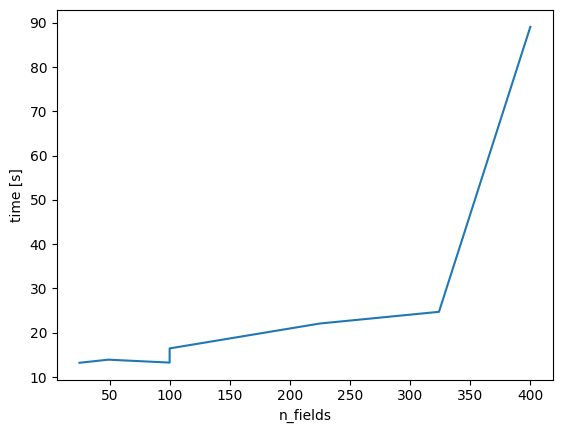

In [ ]:
plt.plot(sizes, times)
plt.ylabel("time [s]")
plt.xlabel("n_fields")